# **Modelado con Random Forest**

## **1. Importación de Librerías y Carga del Dataset**

#### **1.1 Importación de librerías**

In [162]:
import numpy as np
import pandas as pd
import os
import pickle
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    f1_score,
    roc_curve, 
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import optuna
from prettytable import PrettyTable

# Configuración para visualizaciones
plt.style.use('default')
sns.set_theme()  


#### **1.2 Carga y Exploración de datos**

In [144]:
# Carga del dataset
df = pd.read_csv('../../../data/clean/online_shoppers_clean.csv')

# Información básica del dataset
print(f"Dimensiones del dataset: {df.shape}")
print("\nPrimeras 5 filas:")
print(df.head())

# Distribución de la variable objetivo
print("\nDistribución de Revenue:")
print(df['Revenue'].value_counts())
print(df['Revenue'].value_counts(normalize=True) * 100)

# Comprobación de VisitorType
print("\nDistribución de VisitorType:")
print(df['VisitorType'].value_counts())

Dimensiones del dataset: (12205, 18)

Primeras 5 filas:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1 

## **2. Preprocesado de datos**

#### **2.1 Filtración de Registros y Creación de Transformaciones**

In [145]:
# Crear una copia del dataframe para no modificar el original
print("Iniciando preprocesado de datos...")
X = df.copy()

# Filtrar registros - excluir VisitorType='Other'
print(f"Registros antes de filtración: {X.shape[0]}")
X = X[X['VisitorType'] != 'Other']
print(f"Registros después de filtrar 'Other': {X.shape[0]}")

# 1. Crear transformaciones logarítmicas
print("\nCreando transformaciones logarítmicas...")
X['Administrative_Duration_Log'] = np.log1p(X['Administrative_Duration'])
X['Informational_Duration_Log'] = np.log1p(X['Informational_Duration'])
X['ProductRelated_Duration_Log'] = np.log1p(X['ProductRelated_Duration'])

# 2. Crear variable binaria para PageValues
X['PageValues_NonZero'] = (X['PageValues'] > 0).astype(int)

# 3. Crear variables derivadas
X['TotalPages'] = X['Administrative'] + X['Informational'] + X['ProductRelated']
X['TotalDuration'] = X['Administrative_Duration'] + X['Informational_Duration'] + X['ProductRelated_Duration']

# Mostrar las nuevas columnas creadas
print("\nNuevas columnas creadas:")
new_columns = [
    'Administrative_Duration_Log', 
    'Informational_Duration_Log', 
    'ProductRelated_Duration_Log',
    'PageValues_NonZero',
    'TotalPages',
    'TotalDuration'
]
display(X[new_columns].head())

# Mostrar estadísticas descriptivas de las nuevas columnas
print("\nEstadísticas descriptivas de las nuevas columnas:")
display(X[new_columns].describe())

Iniciando preprocesado de datos...
Registros antes de filtración: 12205
Registros después de filtrar 'Other': 12124

Creando transformaciones logarítmicas...

Nuevas columnas creadas:


,Administrative_Duration_Log,Informational_Duration_Log,ProductRelated_Duration_Log,PageValues_NonZero,TotalPages,TotalDuration
0,0.0,0.0,0.000000,0,1,0.000000
1,0.0,0.0,4.174387,0,2,64.000000
2,0.0,0.0,0.000000,0,1,0.000000
3,0.0,0.0,1.299283,0,2,2.666667
4,0.0,0.0,6.443336,0,10,627.500000



Estadísticas descriptivas de las nuevas columnas:


,Administrative_Duration_Log,Informational_Duration_Log,ProductRelated_Duration_Log,PageValues_NonZero,TotalPages,TotalDuration
count,12124.000000,12124.000000,12124.000000,12124.000000,12124.000000,12124.000000
mean,2.334328,0.856555,6.032613,0.223854,35.027714,1327.775670
std,2.365678,1.826606,1.955224,0.416842,46.701179,2047.135858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.281298,0.000000,9.000000,234.396667
50%,2.335245,0.000000,6.421532,0.000000,20.500000,694.534578
75%,4.564348,0.000000,7.302727,0.000000,42.000000,1651.835951
max,8.131457,7.843996,11.066240,1.000000,746.000000,69921.647230


#### **2.2 Codificación de Variables Categóricas**

In [146]:
# 4. Crear variables dummy para Month (todos los meses)
print("\nCreando variables dummy para Month...")
month_dummies = pd.get_dummies(X['Month'], prefix='Month', drop_first=True)
X = pd.concat([X, month_dummies], axis=1)

# 5. Crear variables dummy para VisitorType (excluyendo 'Other')
print("Creando variables dummy para VisitorType...")
# Asegurarse de que solo tenemos los tipos de visitantes que queremos
X = X[X['VisitorType'].isin(['New_Visitor', 'Returning_Visitor'])]

# Crear variables dummy SIN eliminar la primera categoría
visitor_dummies = pd.get_dummies(X['VisitorType'], prefix='VisitorType', drop_first=False)
X = pd.concat([X, visitor_dummies], axis=1)

# Mostrar las variables dummy creadas
print("\nVariables dummy de Month:")
display(X[[col for col in X.columns if col.startswith('Month_')]].head())

print("\nVariables dummy de VisitorType:")
display(X[[col for col in X.columns if col.startswith('VisitorType_')]].head())

# Seleccionar variables finales para el modelo
selected_features = [
    # Variables originales clave
    'PageValues', 'ExitRates', 'BounceRates', 'Weekend',
    
    # Variables transformadas
    'Administrative_Duration_Log', 'Informational_Duration_Log', 'ProductRelated_Duration_Log',
    
    # Variables derivadas
    'PageValues_NonZero', 'TotalPages', 'TotalDuration'
]

# Añadir todas las columnas dummy de meses
month_columns = [col for col in X.columns if col.startswith('Month_')]
selected_features.extend(month_columns)

# Añadir AMBAS columnas de tipo de visitante
visitor_columns = [col for col in X.columns if col.startswith('VisitorType_')]
selected_features.extend(visitor_columns)

# Mostrar las variables seleccionadas
print("\nVariables seleccionadas para el modelo:")
print(selected_features)
print(f"Total de variables seleccionadas: {len(selected_features)}")

# Mostrar las primeras filas de las características seleccionadas
print("\nPrimeras filas de las características seleccionadas:")
display(X[selected_features].head())


Creando variables dummy para Month...
Creando variables dummy para VisitorType...

Variables dummy de Month:


,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,False,True,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False



Variables dummy de VisitorType:


,VisitorType_New_Visitor,VisitorType_Returning_Visitor
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True



Variables seleccionadas para el modelo:
['PageValues', 'ExitRates', 'BounceRates', 'Weekend', 'Administrative_Duration_Log', 'Informational_Duration_Log', 'ProductRelated_Duration_Log', 'PageValues_NonZero', 'TotalPages', 'TotalDuration', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor']
Total de variables seleccionadas: 21

Primeras filas de las características seleccionadas:


,PageValues,ExitRates,BounceRates,Weekend,Administrative_Duration_Log,Informational_Duration_Log,ProductRelated_Duration_Log,PageValues_NonZero,TotalPages,TotalDuration,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Returning_Visitor
0,0.0,0.20,0.20,False,0.0,0.0,0.000000,0,1,0.000000,...,True,False,False,False,False,False,False,False,False,True
1,0.0,0.10,0.00,False,0.0,0.0,4.174387,0,2,64.000000,...,True,False,False,False,False,False,False,False,False,True
2,0.0,0.20,0.20,False,0.0,0.0,0.000000,0,1,0.000000,...,True,False,False,False,False,False,False,False,False,True
3,0.0,0.14,0.05,False,0.0,0.0,1.299283,0,2,2.666667,...,True,False,False,False,False,False,False,False,False,True
4,0.0,0.05,0.02,True,0.0,0.0,6.443336,0,10,627.500000,...,True,False,False,False,False,False,False,False,False,True


#### **2.3. Exportación del preprocesador**

In [147]:
# Crear un diccionario con la información de preprocesado
preprocessor = {
    'selected_features': selected_features,
    'month_columns': month_columns,
    'visitor_columns': visitor_columns,
    'preprocesado_info': {
        'excluir_visitantes': ['Other'],
        'transformaciones_log': ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration'],
        'variables_derivadas': {
            'TotalPages': 'Administrative + Informational + ProductRelated',
            'TotalDuration': 'Administrative_Duration + Informational_Duration + ProductRelated_Duration',
            'PageValues_NonZero': 'PageValues > 0'
        }
    }
}

# Guardar el preprocesador

preproc_path = '../random_forest/export_models/random_forest_preprocessor.pkl'
with open(preproc_path, 'wb') as f:
    pickle.dump(preprocessor, f)

print(f"\nPreprocesador guardado en: {preproc_path}")

# Preparar X e y finales para el modelo
X_final = X[selected_features]
y_final = X['Revenue'].astype(int)

print(f"\nDimensiones de X después del preprocesado: {X_final.shape}")
print(f"Distribución de la variable objetivo: {np.bincount(y_final)}")


Preprocesador guardado en: ../random_forest/export_models/random_forest_preprocessor.pkl

Dimensiones de X después del preprocesado: (12124, 21)
Distribución de la variable objetivo: [10232  1892]


## **3. Entrenamiento del Modelo**

#### **3.1 División en conjuntos de entrenamiento y prueba**

In [148]:
# Preparar X e y finales para el modelo
X_final = X[selected_features]
y_final = X['Revenue'].astype(int)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print(f"Forma del conjunto de entrenamiento: {X_train.shape}")
print(f"Forma del conjunto de prueba: {X_test.shape}")
print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en prueba: {np.bincount(y_test)}")

Forma del conjunto de entrenamiento: (9699, 21)
Forma del conjunto de prueba: (2425, 21)
Distribución de clases en entrenamiento: [8185 1514]
Distribución de clases en prueba: [2047  378]


#### **3.2 Balanceo de clases con SMOTE**

Forma del conjunto de entrenamiento después de SMOTE: (16370, 21)
Distribución de clases después de SMOTE: [8185 8185]


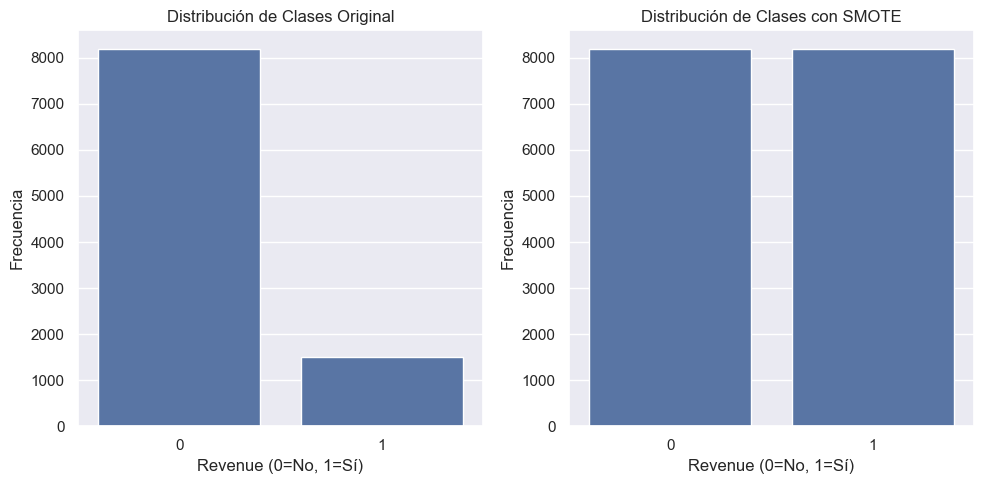

In [149]:
# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Forma del conjunto de entrenamiento después de SMOTE: {X_train_resampled.shape}")
print(f"Distribución de clases después de SMOTE: {np.bincount(y_train_resampled)}")

# Visualizar la distribución de clases antes y después de SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Distribución de Clases Original')
plt.xlabel('Revenue (0=No, 1=Sí)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Distribución de Clases con SMOTE')
plt.xlabel('Revenue (0=No, 1=Sí)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

#### **3.3 Entrentamiento del Modelo Random Forest**

In [150]:
# Entrenar el modelo Random Forest con parámetros iniciales
print("\nEntrenando modelo Random Forest base...")
rf_model_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

# Entrenar en datos con SMOTE
rf_model_base.fit(X_train_resampled, y_train_resampled)
print("Modelo base entrenado con éxito.")

# Evaluar el modelo en datos de entrenamiento y prueba
print("\n--- Métricas del Modelo Base ---")
# Entrenamiento
y_train_pred = rf_model_base.predict(X_train_resampled)
train_accuracy = (y_train_pred == y_train_resampled).mean()
train_f1 = f1_score(y_train_resampled, y_train_pred)

# Prueba
y_test_pred = rf_model_base.predict(X_test)
test_accuracy = (y_test_pred == y_test).mean()
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, rf_model_base.predict_proba(X_test)[:, 1])

# Mostrar métricas
print(f"Precisión en entrenamiento: {train_accuracy:.4f}")
print(f"F1-score en entrenamiento: {train_f1:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"F1-score en prueba: {test_f1:.4f}")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Diferencia (indicador de overfitting): {train_accuracy - test_accuracy:.4f}")

# Verificar overfitting con validación cruzada
print("\nEvaluando con validación cruzada...")
cv_scores = cross_val_score(rf_model_base, X_final, y_final, cv=5, scoring='f1')
print(f"F1-score con validación cruzada (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Informe detallado de clasificación
print("\nInforme de clasificación en conjunto de prueba:")
print(classification_report(y_test, y_test_pred))

# Guardar el modelo entrenado
model_path = '../random_forest/export_models/random_forest_model_base.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_model_base, f)  # Nota: Cambié rf_model por rf_model_base para ser consistente
print(f"Modelo base guardado en: {model_path}")


Entrenando modelo Random Forest base...
Modelo base entrenado con éxito.

--- Métricas del Modelo Base ---
Precisión en entrenamiento: 0.9359
F1-score en entrenamiento: 0.9365
Precisión en prueba: 0.8858
F1-score en prueba: 0.6820
AUC-ROC: 0.9292
Diferencia (indicador de overfitting): 0.0501

Evaluando con validación cruzada...
F1-score con validación cruzada (5-fold): 0.6390 (+/- 0.1047)

Informe de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2047
           1       0.60      0.79      0.68       378

    accuracy                           0.89      2425
   macro avg       0.78      0.84      0.81      2425
weighted avg       0.90      0.89      0.89      2425

Modelo base guardado en: ../random_forest/export_models/random_forest_model_base.pkl


#### **3.4 Optimización de hiperparámetros con Optuna**

[I 2025-05-07 21:54:18,058] A new study created in memory with name: no-name-a001cdb6-c7b7-43cf-b6d0-08737d9a4ef2


Iniciando optimización de hiperparámetros con Optuna...


[I 2025-05-07 21:54:20,457] Trial 0 finished with value: 0.6722689075630253 and parameters: {'n_estimators': 84, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6722689075630253.
[I 2025-05-07 21:54:25,337] Trial 1 finished with value: 0.6908267270668177 and parameters: {'n_estimators': 129, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6908267270668177.
[I 2025-05-07 21:54:27,607] Trial 2 finished with value: 0.6844547563805105 and parameters: {'n_estimators': 113, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.6908267270668177.
[I 2025-05-07 21:54:32,704] Trial 3 finished with value: 0.6852497096399536 and parameters: {'n_est

Optimización completada en 46.01 minutos

Mejores hiperparámetros encontrados:
- n_estimators: 177
- max_depth: 6
- min_samples_split: 3
- min_samples_leaf: 4
- max_features: None
- bootstrap: True
- class_weight: balanced
Mejor F1-score: 0.7022

Importancia de los hiperparámetros:
- max_depth: 0.4972
- bootstrap: 0.2230
- min_samples_leaf: 0.0861
- max_features: 0.0665
- min_samples_split: 0.0536
- n_estimators: 0.0500
- class_weight: 0.0236


/var/folders/cj/h4ygcbgx7zx76v8tmq389b8c0000gn/T/ipykernel_77598/1835679779.py:63: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

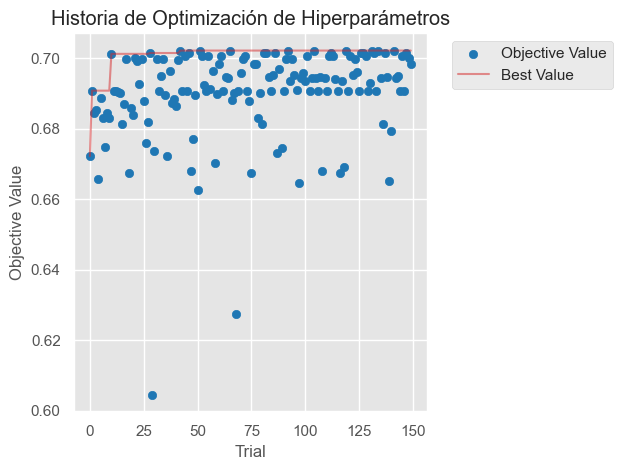

/var/folders/cj/h4ygcbgx7zx76v8tmq389b8c0000gn/T/ipykernel_77598/1835679779.py:70: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 1000x600 with 0 Axes>

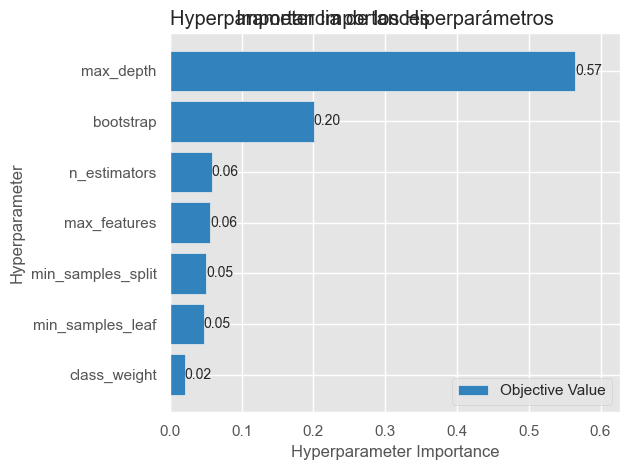


Entrenando modelo optimizado con los mejores hiperparámetros...
Modelo optimizado guardado en: ../random_forest/export_models/random_forest_optimized.pkl


In [151]:
print("Iniciando optimización de hiperparámetros con Optuna...")
start_time = time.time()

def objective(trial):
    # Definir espacio de búsqueda para hiperparámetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # CORRECCIÓN: Para max_features, solo usar 'sqrt', 'log2' o None
    max_features_options = ['sqrt', 'log2', None]
    max_features = trial.suggest_categorical('max_features', max_features_options)
    
    # Parámetros adicionales para explorar
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])
    
    # Configurar modelo con hiperparámetros sugeridos
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight,
        random_state=42
    )
    
    # Entrenar en datos balanceados con SMOTE
    rf_model.fit(X_train_resampled, y_train_resampled)
    
    # Predecir en conjunto de prueba
    y_pred = rf_model.predict(X_test)
    
    # Calcular F1-score para clase positiva (compra)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    return f1

# Crear estudio de Optuna y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)  # Ajustar número de pruebas según recursos disponibles

end_time = time.time()
print(f"Optimización completada en {(end_time - start_time)/60:.2f} minutos")

# Imprimir mejores hiperparámetros y score
print('\nMejores hiperparámetros encontrados:')
for key, value in study.best_params.items():
    print(f"- {key}: {value}")
print(f'Mejor F1-score: {study.best_value:.4f}')

# Visualizar la importancia de los hiperparámetros
param_importance = optuna.importance.get_param_importances(study)
print("\nImportancia de los hiperparámetros:")
for param, importance in param_importance.items():
    print(f"- {param}: {importance:.4f}")

# Graficar la historia de optimización
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Historia de Optimización de Hiperparámetros')
plt.tight_layout()
plt.show()

# Graficar la importancia de los parámetros
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Importancia de los Hiperparámetros')
plt.tight_layout()
plt.show()

# Entrenar modelo final con los mejores hiperparámetros
print("\nEntrenando modelo optimizado con los mejores hiperparámetros...")
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train_resampled, y_train_resampled)

# Guardar el modelo optimizado
model_opt_path = '../random_forest/export_models/random_forest_optimized.pkl'
with open(model_opt_path, 'wb') as f:
    pickle.dump(best_rf, f)

print(f"Modelo optimizado guardado en: {model_opt_path}")

## **4. Evaluación del Modelo**

#### **4.1 Métricas de rendimiento**

In [167]:
# Evaluar en conjunto de entrenamiento (para detectar overfitting)
y_train_pred = rf_model.predict(X_train_resampled)
train_accuracy = (y_train_pred == y_train_resampled).mean()

# Evaluar en conjunto de prueba
y_test_pred = rf_model.predict(X_test)
test_accuracy = (y_test_pred == y_test).mean()

print(f"Precisión en entrenamiento: {train_accuracy:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Diferencia (indicador de overfitting): {train_accuracy - test_accuracy:.4f}")

# Verificar overfitting con validación cruzada
print("\nEvaluando con validación cruzada...")
cv_scores = cross_val_score(rf_model, X_final, y_final, cv=5, scoring='f1')
print(f"F1-score con validación cruzada (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Evaluación detallada en conjunto de prueba
print("\nInforme de clasificación en conjunto de prueba:")
print(classification_report(y_test, y_test_pred))

# Calcular AUC-ROC
y_test_proba = rf_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_proba)
print(f"AUC-ROC: {auc_roc:.4f}")

Precisión en entrenamiento: 0.9214
Precisión en prueba: 0.8940
Diferencia (indicador de overfitting): 0.0274

Evaluando con validación cruzada...
F1-score con validación cruzada (5-fold): 0.6479 (+/- 0.1980)

Informe de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      2047
           1       0.62      0.80      0.70       378

    accuracy                           0.89      2425
   macro avg       0.79      0.86      0.82      2425
weighted avg       0.91      0.89      0.90      2425

AUC-ROC: 0.9305


| Métrica                            | Modelo Base | Modelo Optimizado | Mejora        |
|------------------------------------|:-----------:|:-----------------:|:-------------:|
| **Rendimiento General**            |             |                   |               |
| Precisión en entrenamiento         | 0.9359      | 0.9214            | -0.0145       |
| Precisión en prueba (Accuracy)     | 0.8858      | 0.8940            | +0.0082       |
| Diferencia (overfitting)           | 0.0501      | 0.0274            | -0.0227       |
| F1-score en prueba                 | 0.6820      | 0.7000            | +0.0180       |
| AUC-ROC                            | 0.9292      | 0.9305            | +0.0013       |
| **Clase Positiva (Compras)**       |             |                   |               |
| Precision                          | 0.60        | 0.62              | +0.02         |
| Recall                             | 0.79        | 0.80              | +0.01         |
| F1-score                           | 0.68        | 0.70              | +0.02         |
| **Clase Negativa (No Compras)**    |             |                   |               |
| Precision                          | 0.96        | 0.96              | 0.00          |
| Recall                             | 0.90        | 0.91              | +0.01         |
| F1-score                           | 0.93        | 0.94              | +0.01         |
| **Validación Cruzada**             |             |                   |               |
| F1-score (5-fold)                  | 0.6390      | 0.6479            | +0.0089       |
| Intervalo de confianza             | ±0.1047     | ±0.1980           | +0.0933       |

**Análisis detallado**:

1. **Rendimiento global**: El modelo optimizado muestra una mejora en la precisión en prueba (accuracy) del 0.82%, lo que sugiere una capacidad ligeramente mejor para clasificar correctamente ambas clases.

2. **Control del overfitting**: La diferencia entre precisión de entrenamiento y prueba se redujo en un 45.3% (de 0.0501 a 0.0274), lo que indica que el modelo optimizado tiene mejor capacidad de generalización.

3. **Clase positiva (Compras)**: Todas las métricas para la clase positiva mostraron mejoras, con un aumento del 3.3% en la precisión (de 0.60 a 0.62), indicando menos falsos positivos, y un ligero aumento en el recall (de 0.79 a 0.80), indicando que detecta más compras reales.

4. **Clase negativa (No Compras)**: El rendimiento en la clase mayoritaria era ya muy bueno en el modelo base, pero el modelo optimizado logró mejorar ligeramente el recall (de 0.90 a 0.91) y el F1-score (de 0.93 a 0.94).

5. **Validación cruzada**: El F1-score promedio en validación cruzada mejoró un 1.4% (de 0.6390 a 0.6479), aunque el intervalo de confianza es más amplio, lo que podría indicar mayor variabilidad en el rendimiento.

**Conclusión**: El modelo optimizado supera al modelo base en prácticamente todas las métricas relevantes. La mejora más significativa se observa en la reducción del overfitting, lo que sugiere un modelo más robusto que generalizará mejor a datos nuevos. El aumento del F1-score en la clase positiva (compras) es especialmente valioso desde una perspectiva de negocio, ya que mejora la capacidad del modelo para identificar correctamente a los clientes potenciales, lo que puede traducirse en mejores estrategias de marketing y mayor conversión.

#### **4.2 Visualiazaciones de Evaluación**

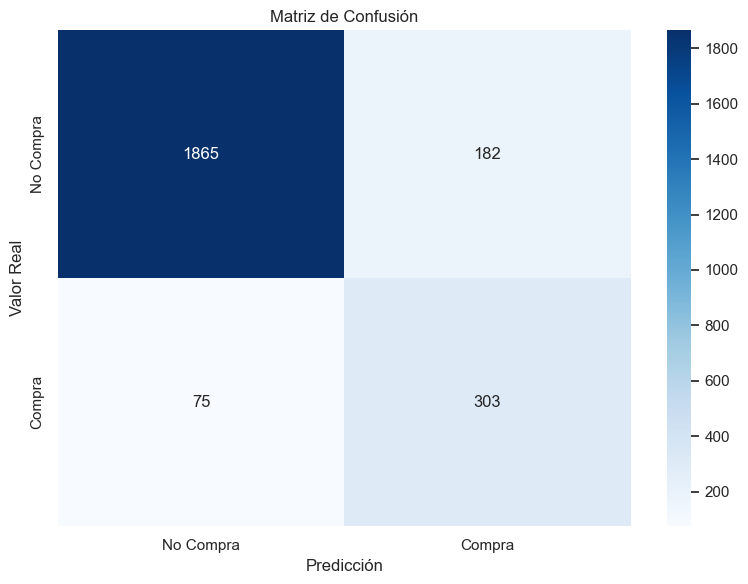

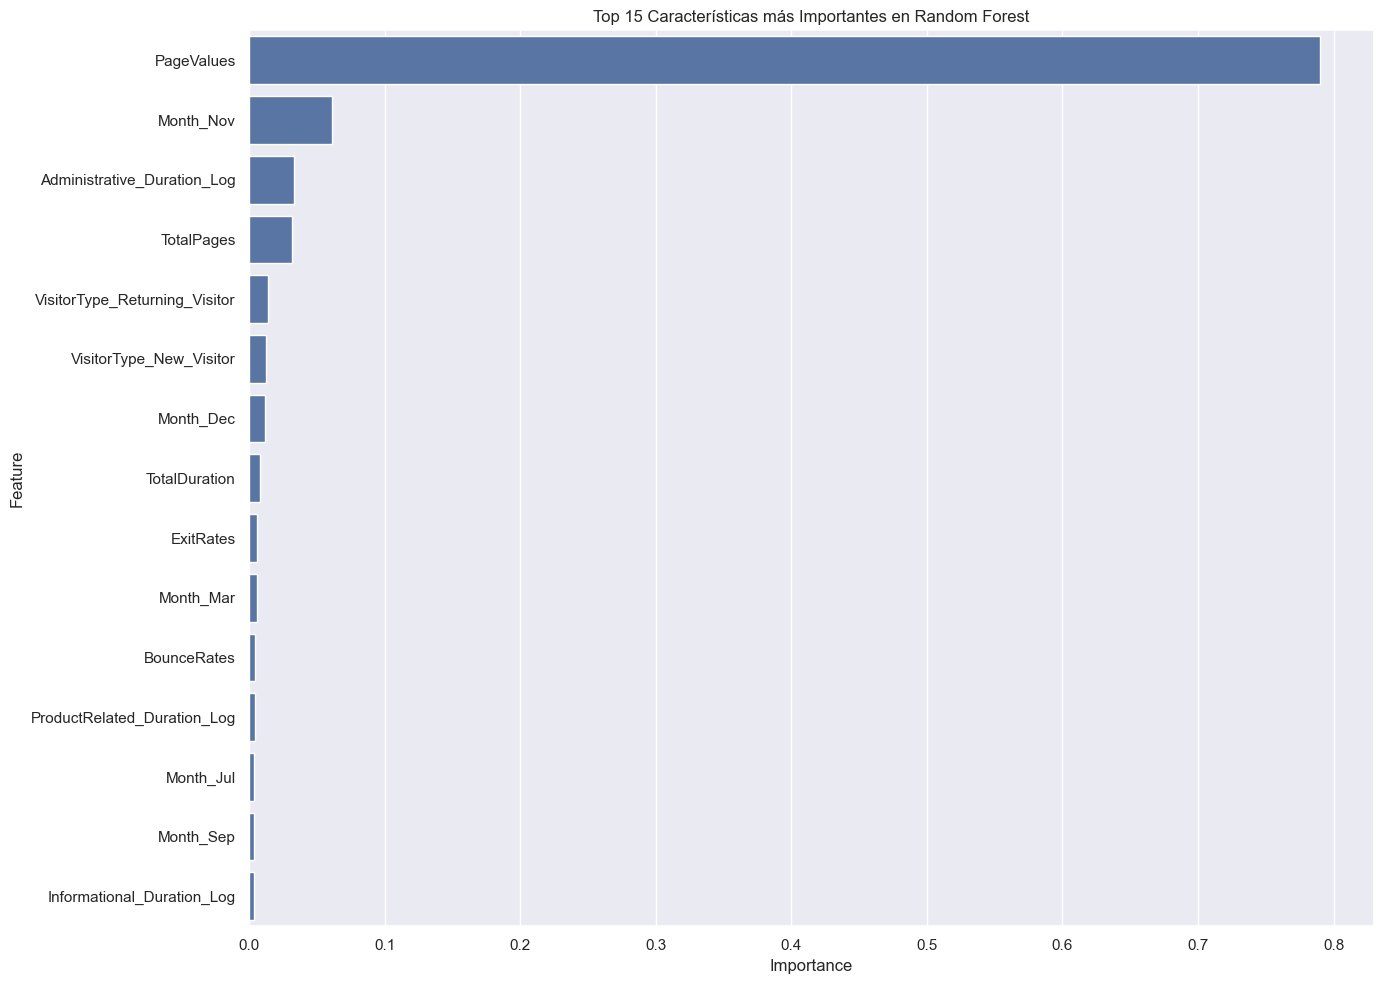

In [166]:
# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Compra', 'Compra'],
            yticklabels=['No Compra', 'Compra'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

# Importancia de características
plt.figure(figsize=(14, 10))
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Mostrar las 15 características más importantes
top_features = feature_importance.head(15)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 15 Características más Importantes en Random Forest')
plt.tight_layout()
plt.show()

#### **4.3 Visualización de la Curva ROC**

<Figure size 800x600 with 0 Axes>

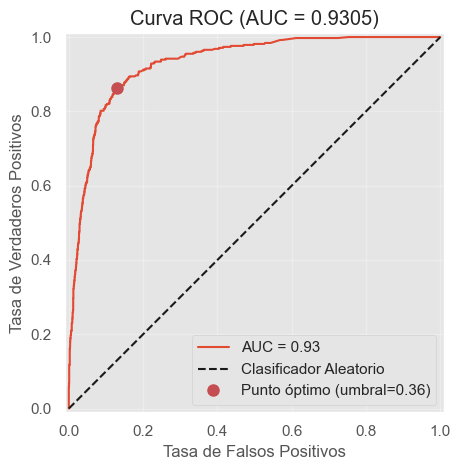

Umbral óptimo basado en la curva ROC: 0.3591
En este punto: FPR = 0.1290, TPR = 0.8624


In [155]:
# Generar la curva ROC
from sklearn.metrics import roc_curve, RocCurveDisplay

# Calcular y graficar la curva ROC
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot()

# Añadir línea de referencia (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')

# Personalizar la gráfica
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title(f'Curva ROC (AUC = {auc_roc:.4f})')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Resaltar el punto de corte óptimo (ejemplo: maximizando la distancia a la línea diagonal)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8, 
         label=f'Punto óptimo (umbral={optimal_threshold:.2f})')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"Umbral óptimo basado en la curva ROC: {optimal_threshold:.4f}")
print(f"En este punto: FPR = {fpr[optimal_idx]:.4f}, TPR = {tpr[optimal_idx]:.4f}")